<a href="https://colab.research.google.com/github/manor-s/DS-course-project-4/blob/main/Classification_Project_Manor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import pandas as pd
csv_file_path = '/content/drive/My Drive/e-commerce project/Churn_Modelling.csv'
churn = pd.read_csv(csv_file_path)



# Label Description and EDA summary

## Label Description:

* **RowNumber** - Serial Row Number (from 1 to 10000)

* **CustomerId** - Unique Ids for bank customer identification

* **Surname** - Customer's last name (2932 unique values)

* **CreditScore** - Credit score of the customer

* **Geography** - The country from which the customer belongs

* **Gender** - Male or Female

* **Age** - Age of the customer

* **Tenure** - Number of years for which the customer has been with the bank

* **Balance** - Bank balance of the customer

* **NumOfProducts** - Number of bank products the customer is utilising

* **HasCrCard** - Binary Flag for whether the customer holds a credit card with the bank or not

* **IsActiveMember** - Binary Flag for whether the customer is an active member with the bank or not

* **EstimatedSalary** - Estimated salary of the customer in Dollars

* **Exited** - Binary flag 1 if the customer closed account with bank and 0 if the customer is retained



## Observations related to churn behavior:
* No unexplainable outliers are present.
* No evident interrelationship among the numerical variables.
* **Product Count**: Customers with three or more products exhibit a significantly higher churn rate. Excluding this group could be considered during the modeling process.
* **Geography**: German customers show a distinct churn pattern compared to those from France and Spain.
* **Gender**: Female customers have a higher churn rate than male customers.
* **Active Membership**: Active members tend to have a lower churn rate.
* **Balance**: Accounts with a balance of zero behave differently than those with a positive balance, potentially warranting a separate categorical consideration.
* **Credit Score**: Lower credit scores may correlate with increased churn risk.
* **Age**: Churn rates appear notably higher among customers aged 40 to 60.



# Model Objectives:

To build an effective churn prediction model, the primary focus will be on recall and precision to ensure that the model captures as many potential churners as possible while minimizing false positives:

Therfore, metric Priorities for Bank Churn Prediction should be prioritized as follows:

* **Recall:** Prioritize high recall to ensure most potential churners are identified.
* **Precision:** Maintain high precision to reduce unnecessary intervention costs on customers who are not at risk.
* **Accuracy:** Not a primary focus due to data imbalance. To be tracked to provide an overall performance picture.
* **F1 Score:** F1 score as a balanced metric to assess the overall performance between recall and precision.

# Pre-Processing

In [67]:
import numpy as np

## Making a new categorical variable of Zero Balance or Blance Percentile:

# Define minimum and maximum for positive balances
min_balance = churn.loc[churn['Balance'] > 0, 'Balance'].min()
max_balance = churn['Balance'].max()

# Calculate evenly spaced cutoffs (10 intervals) from min_balance to max_balance
cutoffs = np.linspace(min_balance, max_balance, 10)

# Define labels for each decile (10 labels, one for each decile)
decile_labels = [f'Decile {i+1}' for i in range(10)]

# Assign each balance to the appropriate decile based on these evenly spaced cutoffs
# Add an additional bin edge (-np.inf) for zero balances
churn['Balance_Category'] = pd.cut(
  churn['Balance'],
  bins=[-np.inf, 0] + list(cutoffs),  # Add zero as a separate category
  labels=['Zero Balance'] + decile_labels,     # Add "Zero Balance" label
  include_lowest=True
)


## Making Dummies

churn_from_col_4 = churn.iloc[:, 3:]
churn_dummies = pd.get_dummies(churn_from_col_4, drop_first=False)


In [43]:
churn_dummies.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
Tenure,10000.0,NaN,NaN,NaN,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0
HasCrCard,10000.0,NaN,NaN,NaN,0.7055,0.45584,0.0,0.0,1.0,1.0,1.0
IsActiveMember,10000.0,NaN,NaN,NaN,0.5151,0.499797,0.0,0.0,1.0,1.0,1.0
EstimatedSalary,10000.0,NaN,NaN,NaN,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,NaN,NaN,NaN,0.2037,0.402769,0.0,0.0,0.0,0.0,1.0
Geography_France,10000,2,True,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = churn_dummies.drop(columns=['Exited'])
y = churn_dummies['Exited']

# Split the data into training and testing sets, keeping the "Exited" category stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the distribution of the "Exited" category in the train and test sets
print("Train 'Exited' distribution:\n", y_train.value_counts(normalize=True))
print("Test 'Exited' distribution:\n", y_test.value_counts(normalize=True))


Train 'Exited' distribution:
 Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64
Test 'Exited' distribution:
 Exited
0    0.7965
1    0.2035
Name: proportion, dtype: float64


In [63]:
!pip install optuna

Best Parameters: {'C': 22.605563701229375, 'solver': 'liblinear'}
Best Cross-Validation Score: 0.49532530267222424
Optimal Threshold for Best F1: 0.62
Test Accuracy: 0.791
Precision: 0.48775055679287305
Recall: 0.538083538083538
F1 Score: 0.5116822429906542


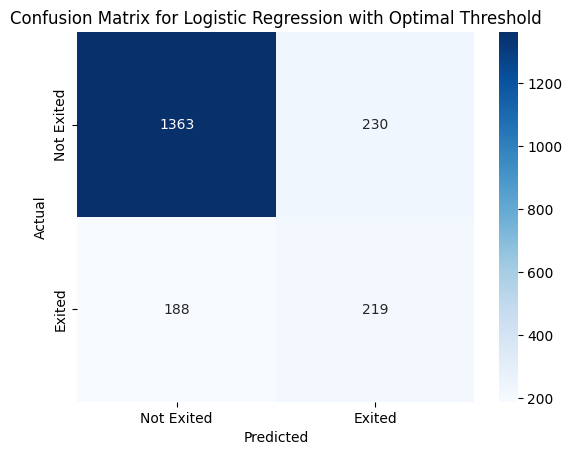


Feature Impact:
                          Feature  Coefficient
1                             Age     0.801177
6                  IsActiveMember    -0.441838
13  Balance_Category_Zero Balance    -0.267735
9               Geography_Germany     0.246710
3                         Balance    -0.234232
21      Balance_Category_Decile 8     0.141153
19      Balance_Category_Decile 6     0.139155
12                    Gender_Male    -0.134449
11                  Gender_Female     0.134449
8                Geography_France    -0.133586
22      Balance_Category_Decile 9     0.116870
23     Balance_Category_Decile 10     0.097739
10                Geography_Spain    -0.092632
14      Balance_Category_Decile 1     0.091909
0                     CreditScore    -0.088725
20      Balance_Category_Decile 7     0.076380
4                   NumOfProducts    -0.054721
18      Balance_Category_Decile 5     0.050069
7                 EstimatedSalary     0.046312
15      Balance_Category_Decile 2     0.045

In [73]:
## logistic regression

import optuna
import logging
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Suppress Optuna's verbose output by setting the logging level to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)  # Regularization strength
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])

    # Create a pipeline with scaling and logistic regression
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('log_reg', LogisticRegression(C=C, solver=solver, max_iter=1000,
                                       random_state=42, class_weight='balanced'))
    ])

    # Perform cross-validation and return the mean F1 score
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Cross-Validation Score:", study.best_value)

# Train the final model with the best parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(**study.best_params, max_iter=1000,
                                   random_state=42, class_weight='balanced'))
])
best_model.fit(X_train, y_train)

# Predict probabilities and find the optimal threshold using the Precision-Recall curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1: {optimal_threshold:.2f}")

# Use the optimal threshold to make final predictions
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

# Print evaluation results
print("Test Accuracy:", accuracy)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression with Optimal Threshold')
plt.show()

# Evaluate the impact of each variable
# Extract the coefficients and match them to feature names
coefficients = best_model.named_steps['log_reg'].coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display feature impact
print("\nFeature Impact:")
print(feature_importance[['Feature', 'Coefficient']])



Best Parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 2}
Best Cross-Validation Score: 0.5646924031076506
Optimal Threshold for Best F1: 0.65
Test Accuracy: 0.811
Precision: 0.5287128712871287
Recall: 0.6560196560196561
F1 Score: 0.5855263157894737


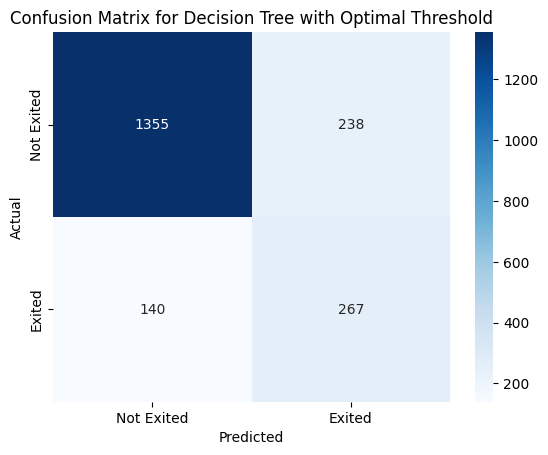


Feature Impact:
                          Feature  Importance
1                             Age    0.427240
4                   NumOfProducts    0.313522
3                         Balance    0.115484
6                  IsActiveMember    0.064871
9               Geography_Germany    0.044901
7                 EstimatedSalary    0.011825
12                    Gender_Male    0.008669
19      Balance_Category_Decile 6    0.005178
0                     CreditScore    0.004302
21      Balance_Category_Decile 8    0.002520
10                Geography_Spain    0.001490
8                Geography_France    0.000000
11                  Gender_Female    0.000000
5                       HasCrCard    0.000000
13  Balance_Category_Zero Balance    0.000000
14      Balance_Category_Decile 1    0.000000
15      Balance_Category_Decile 2    0.000000
16      Balance_Category_Decile 3    0.000000
17      Balance_Category_Decile 4    0.000000
18      Balance_Category_Decile 5    0.000000
2                

In [74]:
## decision tree

import optuna
import logging
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Suppress Optuna's verbose output by setting the logging level to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Create a pipeline with scaling and decision tree
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('tree', DecisionTreeClassifier(
            max_depth=max_depth, min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf, random_state=42, class_weight='balanced'
        ))
    ])

    # Perform cross-validation and return the mean F1 score
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Cross-Validation Score:", study.best_value)

# Train the final model with the best parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('tree', DecisionTreeClassifier(**study.best_params, random_state=42, class_weight='balanced'))
])
best_model.fit(X_train, y_train)

# Predict probabilities and find the optimal threshold using the Precision-Recall curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1: {optimal_threshold:.2f}")

# Use the optimal threshold to make final predictions
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

# Print evaluation results
print("Test Accuracy:", accuracy)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree with Optimal Threshold')
plt.show()

# Evaluate the impact of each variable
# Extract the feature importances
importances = best_model.named_steps['tree'].feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display feature impact
print("\nFeature Impact:")
print(feature_importance)


In [76]:
# support vector

import optuna
import logging
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Suppress Optuna's verbose output by setting the logging level to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)  # Regularization strength
    gamma = trial.suggest_float('gamma', 1e-4, 1e1, log=True)  # Kernel coefficient

    # Create a pipeline with scaling and SVC with probability enabled
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(C=C, gamma=gamma, kernel='rbf', probability=True, random_state=42))
    ])

    # Perform cross-validation and return the mean F1 score
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Cross-Validation Score:", study.best_value)

# Train the final model with the best parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(**study.best_params, kernel='rbf', probability=True, random_state=42))
])
best_model.fit(X_train, y_train)

# Predict probabilities and find the optimal threshold using the Precision-Recall curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1: {optimal_threshold:.2f}")

# Use the optimal threshold to make final predictions
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

# Print evaluation results
print("Test Accuracy:", accuracy)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM (RBF Kernel) with Optimal Threshold')
plt.show()



[W 2024-10-26 21:43:37,421] Trial 0 failed with parameters: {'C': 0.007010565015545511, 'gamma': 4.770165292739755} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-76-1aeaffde4eb3>", line 31, in objective
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 712, in cross_val_score
    cv_results = cross_validate(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", 

KeyboardInterrupt: 

In [ ]:
# random forest

import optuna
import logging
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Suppress Optuna's verbose output by setting the logging level to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 300)  # Number of trees
    max_depth = trial.suggest_int('max_depth', 3, 20)  # Depth of each tree
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Minimum samples to split
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)  # Minimum samples in leaf nodes

    # Create a pipeline with scaling and random forest
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth,
            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
            random_state=42, class_weight='balanced'
        ))
    ])

    # Perform cross-validation and return the mean F1 score
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Cross-Validation Score:", study.best_value)

# Train the final model with the best parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(**study.best_params, random_state=42, class_weight='balanced'))
])
best_model.fit(X_train, y_train)

# Predict probabilities and find the optimal threshold using the Precision-Recall curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1: {optimal_threshold:.2f}")

# Use the optimal threshold to make final predictions
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

# Print evaluation results
print("Test Accuracy:", accuracy)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest with Optimal Threshold')
plt.show()

# Evaluate the impact of each variable
# Extract the feature importances
importances = best_model.named_steps['rf'].feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display feature impact
print("\nFeature Impact:")
print(feature_importance)



In [ ]:
## xgboost

import optuna
import logging
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Suppress Optuna's verbose output by setting the logging level to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 300)  # Number of boosting rounds
    max_depth = trial.suggest_int('max_depth', 3, 20)  # Depth of each tree
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)  # Learning rate
    subsample = trial.suggest_float('subsample', 0.6, 1.0)  # Fraction of samples per tree
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0)  # Adjust class weight

    # Create a pipeline with scaling and XGBoost
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBClassifier(
            n_estimators=n_estimators, max_depth=max_depth,
            learning_rate=learning_rate, subsample=subsample,
            scale_pos_weight=scale_pos_weight,
            eval_metric='logloss', random_state=42))
    ])

    # Perform cross-validation and return the mean F1 score
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Cross-Validation Score:", study.best_value)

# Train the final model with the best parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(**study.best_params, eval_metric='logloss', random_state=42))
])
best_model.fit(X_train, y_train)

# Predict probabilities and find the optimal threshold using the Precision-Recall curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1: {optimal_threshold:.2f}")

# Use the optimal threshold to make final predictions
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

# Print evaluation results
print("Test Accuracy:", accuracy)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost with Optimal Threshold')
plt.show()

# Evaluate the impact of each variable
# Extract the feature importances
importances = best_model.named_steps['xgb'].feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display feature impact
print("\nFeature Impact:")
print(feature_importance)

